In [1]:
"""
this block is needed at the beginning of all notebooks to be able to load modules
"""
import os
import sys
from pathlib import Path
import pandas as pd
import math
import numpy as np
from scipy.signal import detrend
import pywt

# Automatically find and append the project root
root_path = Path.cwd().resolve().parents[2]  # adjust level as needed
data_path = os.path.join(root_path, "data")
src_path = os.path.join(root_path, "src")

print(src_path)

if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

E:\vatecas\src


In [2]:
initial_time = pd.to_datetime('2023-01-01T12:00:00+00:00')
final_time = pd.Timestamp('2024-01-01T12:00:00+00:00')

In [3]:
tickers = ["SPY", "NVDA", "TSLA"]  # List of tickers
data_files = [os.path.join(data_path, f"{ticker}.parquet") for ticker in tickers]
data = {
    ticker: pd.read_parquet(path).loc[initial_time:final_time]
    for ticker, path in zip(tickers, data_files)
}
timeline = pd.DatetimeIndex(
    pd.to_datetime(sorted(set().union(*[df.index for df in data.values()])))
)
data = {tk: df.reindex(timeline).ffill() for tk, df in data.items()}
closing_data = {tk: df['adjClose'] for tk, df in data.items()}

<h1>Kalman</h1>

In [ ]:
from signal_generator.regression.Kalman_filter import KalmanFilter
from signal_generator.regression.UKF_log import UKFlog
from signal_generator.regression.lag import Lag
from signal_generator.regression.VAR import VAROracle

from signal_generator.regression.base.oracle_diagnostics import oracle_diagnostics

kalman1 = KalmanFilter(process_noise=1e+3, obs_noise_scale=1e-3)
ukf_log = UKFlog(process_noise=1, obs_noise_scale=1)
lag = Lag(lag_days=1)
var = VAROracle(lag=5)

KalmanOracle is regressing:   1%|          | 2/210 [00:00<00:14, 14.85it/s]

[5.94729685 3.12145895 5.31207233]
[5.94729685 3.12145895 5.31207233 0.00780008 0.04635332 0.03446531]
[5.95504403 3.14823617 5.25174973]
[5.95504403 3.14823617 5.25174973 0.00834176 0.04698796 0.03705461]
[5.97095459 3.1726421  5.28720586]
[5.97095459 3.1726421  5.28720586 0.00951516 0.04571035 0.03582633]
[5.9716471  3.15847779 5.2668783 ]
[5.9716471  3.15847779 5.2668783  0.00951324 0.04476731 0.034408  ]


KalmanOracle is regressing:   3%|▎         | 6/210 [00:00<00:14, 14.46it/s]

[5.9561997  3.14729209 5.23489822]
[5.9561997  3.14729209 5.23489822 0.00858649 0.04293837 0.03196913]
[5.95783043 3.18492108 5.20400669]
[5.95783043 3.18492108 5.20400669 0.00859283 0.04351193 0.03185421]
[5.93920829 3.15362719 5.15282906]
[5.93920829 3.15362719 5.15282906 0.01002154 0.0224197  0.03357873]
[5.92467371 3.1333252  5.15583172]
[5.92467371 3.1333252  5.15583172 0.01039878 0.02273666 0.03380432]


KalmanOracle is regressing:   5%|▍         | 10/210 [00:00<00:13, 14.65it/s]

[5.92324749 3.13336875 5.16181012]
[5.92324749 3.13336875 5.16181012 0.01021593 0.02247586 0.02686603]
[5.93964236 3.18002928 5.21090591]
[5.93964236 3.18002928 5.21090591 0.01177005 0.02646238 0.03351455]
[5.93336841 3.18686287 5.19545373]
[5.93336841 3.18686287 5.19545373 0.011848   0.02498394 0.033525  ]


KalmanOracle is regressing:   7%|▋         | 14/210 [00:00<00:13, 14.36it/s]

[5.95076148 3.23963889 5.21564203]
[5.95076148 3.23963889 5.21564203 0.01289891 0.02811153 0.03039346]
[5.93904535 3.24681717 5.19367881]
[5.93904535 3.24681717 5.19367881 0.01203309 0.02764727 0.02778221]
[5.94861504 3.25359685 5.21085134]
[5.94861504 3.25359685 5.21085134 0.0126009  0.02671045 0.02856752]
[5.96166008 3.26507513 5.28614357]
[5.96166008 3.26507513 5.28614357 0.01252774 0.02580425 0.03585877]


KalmanOracle is regressing:   8%|▊         | 16/210 [00:01<00:14, 13.17it/s]

[5.94446666 3.27529034 5.25305846]
[5.94446666 3.27529034 5.25305846 0.01359235 0.02432617 0.03608442]
[5.94716634 3.30223992 5.25864055]
[5.94716634 3.30223992 5.25864055 0.012327   0.02067047 0.03090933]
[5.95370695 3.28697188 5.24917964]
[5.95370695 3.28697188 5.24917964 0.01128324 0.01985313 0.03143657]


KalmanOracle is regressing:  10%|▉         | 20/210 [00:01<00:13, 14.17it/s]

[5.95557507 3.27766774 5.2565053 ]
[5.95557507 3.27766774 5.2565053  0.01119981 0.02075221 0.03142479]
[5.95332785 3.27309661 5.2427518 ]
[5.95332785 3.27309661 5.2427518  0.01037494 0.01834748 0.02906757]
[5.96775812 3.29459798 5.26723941]
[5.96775812 3.29459798 5.26723941 0.01070386 0.01867453 0.02897621]
[5.97359628 3.30927627 5.27443443]
[5.97359628 3.30927627 5.27443443 0.00971295 0.01262249 0.02865322]


KalmanOracle is regressing:  11%|█▏        | 24/210 [00:01<00:12, 14.65it/s]

[5.9875925  3.32356222 5.33493855]
[5.9875925  3.32356222 5.33493855 0.00904711 0.01281323 0.03120683]
[5.9913958  3.33030761 5.27181938]
[5.9913958  3.33030761 5.27181938 0.00891095 0.01281348 0.03879628]
[5.98583224 3.31182934 5.26051165]
[5.98583224 3.31182934 5.26051165 0.00882848 0.01490438 0.03133125]
[5.98321055 3.2907736  5.22316269]
[5.98321055 3.2907736  5.22316269 0.00631666 0.01659826 0.03176967]


KalmanOracle is regressing:  13%|█▎        | 28/210 [00:01<00:12, 15.03it/s]

[5.98710385 3.29656018 5.2206801 ]
[5.98710385 3.29656018 5.2206801  0.0063046  0.01443251 0.03164395]
[5.98812974 3.3164085  5.21770366]
[5.98812974 3.3164085  5.21770366 0.00629889 0.01469827 0.03158761]
[5.98839825 3.3014305  5.22998499]
[5.98839825 3.3014305  5.22998499 0.00635688 0.01525893 0.03178629]
[5.98431397 3.27630992 5.19595236]
[5.98431397 3.27630992 5.19595236 0.00653798 0.01730298 0.03305156]


KalmanOracle is regressing:  15%|█▌        | 32/210 [00:02<00:12, 14.38it/s]

[5.99750921 3.27510141 5.22520889]
[5.99750921 3.27510141 5.22520889 0.00633116 0.01579906 0.03350033]
[5.99506348 3.28618738 5.22035583]
[5.99506348 3.28618738 5.22035583 0.0064433  0.01545397 0.0332847 ]
[5.99864529 3.29526482 5.2313225 ]
[5.99864529e+00 3.29526482e+00 5.23132250e+00 5.15717260e-03
 1.49659606e-02 2.59943252e-02]


KalmanOracle is regressing:  17%|█▋        | 36/210 [00:02<00:11, 14.91it/s]

[5.99929734 3.31959425 5.21661912]
[5.99929734e+00 3.31959425e+00 5.21661912e+00 5.07835915e-03
 1.68962048e-02 1.93858977e-02]
[5.99912833 3.32909107 5.19622927]
[5.99912833e+00 3.32909107e+00 5.19622927e+00 4.64260061e-03
 1.60786848e-02 1.98431251e-02]
[5.9936563  3.2990352  5.09368885]
[5.99365630e+00 3.29903520e+00 5.09368885e+00 4.95353030e-03
 1.75163450e-02 3.43423410e-02]
[5.99443292 3.29958847 5.1064302 ]
[5.99443292e+00 3.29958847e+00 5.10643020e+00 4.86168542e-03
 1.74383295e-02 3.51015477e-02]


KalmanOracle is regressing:  19%|█▉        | 40/210 [00:02<00:10, 15.80it/s]

[5.99547556 3.2967451  5.09098565]
[5.99547556e+00 3.29674510e+00 5.09098565e+00 4.86178894e-03
 1.61781787e-02 3.50006000e-02]
[5.97947444 3.26667696 5.07935257]
[5.97947444 3.26667696 5.07935257 0.00699833 0.01793034 0.03401713]
[5.97522982 3.29355979 5.03532791]
[5.97522982 3.29355979 5.03532791 0.00700581 0.01843269 0.03469956]
[5.99494225 3.30352628 5.07636061]
[5.99494225 3.30352628 5.07636061 0.00844317 0.01855928 0.03637688]


KalmanOracle is regressing:  20%|██        | 42/210 [00:02<00:11, 14.62it/s]

[6.00344123 3.32255369 5.10175489]
[6.00344123 3.32255369 5.10175489 0.00879069 0.01905822 0.03829236]
[6.00243093 3.36354144 5.0865464 ]
[6.00243093 3.36354144 5.0865464  0.00875523 0.02212654 0.03752957]
[5.9911281  3.33903041 5.07710944]
[5.9911281  3.33903041 5.07710944 0.00942671 0.0230935  0.03755965]


KalmanOracle is regressing:  22%|██▏       | 46/210 [00:03<00:10, 14.92it/s]

[5.98424044 3.32446184 5.07897907]
[5.98424044 3.32446184 5.07897907 0.00959452 0.02343242 0.03777109]
[5.97713225 3.3157919  5.08264583]
[5.97713225 3.3157919  5.08264583 0.00967467 0.02153291 0.02264515]
[5.99547556 3.3555539  5.13615132]
[5.99547556 3.3555539  5.13615132 0.01139764 0.02435619 0.0278431 ]
[5.99574211 3.3718431  5.1462728 ]
[5.99574211 3.3718431  5.1462728  0.01139362 0.02436952 0.02720103]


KalmanOracle is regressing:  24%|██▍       | 50/210 [00:03<00:10, 15.64it/s]

[5.99134714 3.3517461  5.1307859 ]
[5.99134714 3.3517461  5.1307859  0.01023395 0.0229757  0.02746744]
[5.99600858 3.36267631 5.12717311]
[5.99600858 3.36267631 5.12717311 0.01010926 0.02218462 0.02245099]
[5.99426308 3.35199108 5.14795948]
[5.99426308 3.35199108 5.14795948 0.00824358 0.02275795 0.02029723]
[5.99295196 3.34362812 5.12384492]
[5.99295196 3.34362812 5.12384492 0.00773367 0.02253356 0.02126091]


KalmanOracle is regressing:  26%|██▌       | 54/210 [00:03<00:10, 14.40it/s]

[5.99639606 3.36502771 5.114094  ]
[5.99639606 3.36502771 5.114094   0.00785047 0.01974779 0.02087332]
[5.98969098 3.3739677  5.11511542]
[5.98969098 3.3739677  5.11511542 0.00732761 0.01804728 0.02049483]
[6.00175683 3.40646707 5.15825038]
[6.00175683 3.40646707 5.15825038 0.00777565 0.01884299 0.02360839]
[6.01134395 3.45497632 5.17552807]
[6.01134395 3.45497632 5.17552807 0.00748086 0.0213631  0.02371565]


KalmanOracle is regressing:  28%|██▊       | 58/210 [00:03<00:09, 15.22it/s]

[6.00988784 3.44182116 5.19373433]
[6.00988784e+00 3.44182116e+00 5.19373433e+00 5.67052002e-03
 2.08539847e-02 1.90370180e-02]
[6.01029385 3.43900245 5.24105895]
[6.01029385e+00 3.43900245e+00 5.24105895e+00 5.66778459e-03
 2.09395797e-02 2.27912151e-02]
[5.99900759 3.42322558 5.22450935]
[5.99900759 3.42322558 5.22450935 0.0066679  0.02042005 0.02290955]
[5.99173642 3.41832569 5.20893956]
[5.99173642 3.41832569 5.20893956 0.00692671 0.02067746 0.02384884]


KalmanOracle is regressing:  30%|██▉       | 62/210 [00:04<00:09, 15.90it/s]

[6.00035904 3.63641359 5.21748685]
[6.00035904 3.63641359 5.21748685 0.00741083 0.06629012 0.02348154]
[6.01322658 3.66152996 5.26357063]
[6.01322658 3.66152996 5.26357063 0.00821991 0.06518293 0.02363706]
[6.01360744 3.69100449 5.30410061]
[6.01360744 3.69100449 5.30410061 0.00821849 0.06509917 0.02340252]
[6.00804677 3.63256205 5.3177768 ]
[6.00804677 3.63256205 5.3177768  0.00810758 0.07046531 0.02272854]


KalmanOracle is regressing:  31%|███▏      | 66/210 [00:04<00:09, 15.40it/s]

[6.01750293 3.68246674 5.33522772]
[6.01750293 3.68246674 5.33522772 0.00781065 0.07082189 0.02141224]
[6.03186051 3.67126519 5.36583582]
[6.03186051 3.67126519 5.36583582 0.00840827 0.07132266 0.02175677]
[6.02994243 3.66729056 5.38270447]
[6.02994243 3.66729056 5.38270447 0.00842866 0.070927   0.02176554]
[6.03211754 3.65400415 5.39956443]
[6.03211754 3.65400415 5.39956443 0.00841178 0.0713695  0.01959744]


KalmanOracle is regressing:  34%|███▍      | 72/210 [00:04<00:08, 16.49it/s]

[6.02865384 3.62313466 5.41418746]
[6.02865384 3.62313466 5.41418746 0.00742924 0.07229542 0.01641695]
[6.03468415 3.65037856 5.45898959]
[6.03468415 3.65037856 5.45898959 0.00662472 0.07183036 0.01343596]
[6.03647687 3.65710737 5.49880623]
[6.03647687 3.65710737 5.49880623 0.00649411 0.03069363 0.01286857]
[6.04550785 3.67530549 5.52078069]
[6.04550785e+00 3.67530549e+00 5.52078069e+00 6.03292300e-03
 3.02409890e-02 1.14608959e-02]


KalmanOracle is regressing:  35%|███▌      | 74/210 [00:04<00:08, 16.99it/s]

[6.05207911 3.71356912 5.55570774]
[6.05207911e+00 3.71356912e+00 5.55570774e+00 6.02660042e-03
 3.11586133e-02 1.08435589e-02]
[6.05326926 3.76059096 5.54825863]
[6.05326926e+00 3.76059096e+00 5.54825863e+00 5.26492190e-03
 2.62981029e-02 1.43621248e-02]
[6.06559068 3.75255823 5.54478674]
[6.06559068e+00 3.75255823e+00 5.54478674e+00 5.59335816e-03
 2.37440675e-02 1.64040077e-02]
[6.06219216 3.75347217 5.5627564 ]
[6.06219216e+00 3.75347217e+00 5.56275640e+00 5.07453139e-03
 2.30838707e-02 1.60956344e-02]


KalmanOracle is regressing:  37%|███▋      | 78/210 [00:05<00:08, 15.58it/s]

[6.05699047 3.77927707 5.61476909]
[6.05699047e+00 3.77927707e+00 5.61476909e+00 5.47474618e-03
 2.32388619e-02 1.87185363e-02]
[6.05185355 3.7617067  5.55860255]
[6.05185355e+00 3.76170670e+00 5.55860255e+00 5.96316963e-03
 2.37207712e-02 3.03814836e-02]
[6.05545674 3.76124196 5.57825704]
[6.05545674e+00 3.76124196e+00 5.57825704e+00 5.68938694e-03
 1.98158068e-02 3.03977649e-02]
[6.04786805 3.74209408 5.54751845]
[6.04786805 3.74209408 5.54751845 0.00631959 0.02148781 0.03175849]


KalmanOracle is regressing:  39%|███▉      | 82/210 [00:05<00:07, 16.24it/s]

[6.04377391 3.70401655 5.48500438]
[6.04377391 3.70401655 5.48500438 0.00651903 0.02577404 0.03629511]
[6.05467753 3.73417349 5.52230057]
[6.05467753 3.73417349 5.52230057 0.00677661 0.02663603 0.03755036]
[6.05518179 3.71588228 5.54611451]
[6.05518179 3.71588228 5.54611451 0.00650956 0.02512221 0.0366586 ]
[6.05911548 3.70868177 5.55101972]
[6.05911548 3.70868177 5.55101972 0.00659807 0.01970565 0.03662723]


KalmanOracle is regressing:  41%|████      | 86/210 [00:05<00:07, 15.62it/s]

[6.07084708 3.74429498 5.56746626]
[6.07084708 3.74429498 5.56746626 0.00649472 0.02312905 0.03690976]
[6.07199693 3.74691554 5.63414654]
[6.07199693 3.74691554 5.63414654 0.00636188 0.02314755 0.04157936]
[6.07050864 3.74464951 5.64360775]
[6.07050864 3.74464951 5.64360775 0.00609288 0.02140497 0.03885758]
[6.06264716 3.73957961 5.62235548]
[6.06264716 3.73957961 5.62235548 0.00642861 0.02090373 0.03474596]


KalmanOracle is regressing:  43%|████▎     | 90/210 [00:05<00:07, 15.24it/s]

[6.06011929 3.74903528 5.61469622]
[6.06011929 3.74903528 5.61469622 0.006451   0.02119649 0.03466821]
[6.06264716 3.74140679 5.59697647]
[6.06264716e+00 3.74140679e+00 5.59697647e+00 5.87612007e-03
 2.04922386e-02 3.35799733e-02]
[6.06899552 3.7467269  5.59764388]
[6.06899552e+00 3.74672690e+00 5.59764388e+00 5.71888760e-03
 1.61100998e-02 2.51881446e-02]
[6.07700925 3.78142049 5.6057653 ]
[6.07700925e+00 3.78142049e+00 5.60576530e+00 5.34911204e-03
 1.68782327e-02 2.36463694e-02]


KalmanOracle is regressing:  45%|████▍     | 94/210 [00:06<00:07, 15.62it/s]

[6.08491478 3.82760189 5.62726134]
[6.08491478e+00 3.82760189e+00 5.62726134e+00 5.56631538e-03
 1.90315556e-02 2.35045507e-02]
[6.08429176 3.81649139 5.63970607]
[6.08429176e+00 3.81649139e+00 5.63970607e+00 5.65485210e-03
 1.94407626e-02 2.35104301e-02]
[6.08775797 3.83807387 5.67119041]
[6.08775797e+00 3.83807387e+00 5.67119041e+00 4.78481237e-03
 1.80548561e-02 2.44107257e-02]
[6.09516107 3.860064   5.68133235]
[6.09516107e+00 3.86006400e+00 5.68133235e+00 5.07314654e-03
 1.82638097e-02 1.57119505e-02]


KalmanOracle is regressing:  47%|████▋     | 98/210 [00:06<00:07, 15.99it/s]

[6.09738234 3.85124518 5.67421634]
[6.09738234e+00 3.85124518e+00 5.67421634e+00 4.91452236e-03
 1.88475419e-02 1.59960569e-02]
[6.09072579 3.81761241 5.57177373]
[6.09072579e+00 3.81761241e+00 5.57177373e+00 4.66273272e-03
 2.27708355e-02 3.52695396e-02]
[6.09072579 3.79064843 5.56075855]
[6.09072579e+00 3.79064843e+00 5.56075855e+00 4.42928656e-03
 2.50169982e-02 3.53086368e-02]
[6.09518309 3.7974635  5.5949344 ]
[6.09518309e+00 3.79746350e+00 5.59493440e+00 4.44387555e-03
 2.47096809e-02 3.68937770e-02]


KalmanOracle is regressing:  49%|████▊     | 102/210 [00:06<00:06, 15.70it/s]

[6.09790944 3.82109929 5.58078587]
[6.09790944e+00 3.82109929e+00 5.58078587e+00 4.32283213e-03
 2.52925693e-02 3.71257877e-02]
[6.09806313 3.81611744 5.57727398]
[6.09806313e+00 3.81611744e+00 5.57727398e+00 4.02426943e-03
 2.37719398e-02 3.69822399e-02]
[6.09141112 3.82592573 5.54404399]
[6.09141112e+00 3.82592573e+00 5.54404399e+00 4.28725468e-03
 1.93252154e-02 3.70238793e-02]
[6.10115378 3.84427487 5.58514908]
[6.10115378e+00 3.84427487e+00 5.58514908e+00 5.04107339e-03
 1.96747962e-02 3.95440254e-02]


KalmanOracle is regressing:  50%|█████     | 106/210 [00:06<00:06, 16.32it/s]

[6.10305602 3.84382557 5.58885785]
[6.10305602e+00 3.84382557e+00 5.58885785e+00 5.00757289e-03
 1.86527709e-02 3.77883212e-02]
[6.10019034 3.83906346 5.56478857]
[6.10019034e+00 3.83906346e+00 5.56478857e+00 4.74381397e-03
 1.72556547e-02 3.75175471e-02]
[6.08618189 3.78974527 5.53776724]
[6.08618189 3.78974527 5.53776724 0.00637436 0.02235613 0.03775127]
[6.08331193 3.79528683 5.55806282]
[6.08331193 3.79528683 5.55806282 0.00614248 0.02055698 0.02451948]


KalmanOracle is regressing:  52%|█████▏    | 110/210 [00:07<00:06, 16.49it/s]

[6.0787789  3.79898659 5.53678293]
[6.0787789  3.79898659 5.53678293 0.00623757 0.01885581 0.02510948]
[6.08746957 3.81533609 5.52724416]
[6.08746957 3.81533609 5.52724416 0.00673094 0.01936824 0.02197077]
[6.0831114  3.79862842 5.5202602 ]
[6.0831114  3.79862842 5.5202602  0.00669827 0.01858287 0.02183484]
[6.07640371 3.75023447 5.48972254]
[6.07640371 3.75023447 5.48972254 0.0068456  0.02320953 0.02299484]


KalmanOracle is regressing:  54%|█████▍    | 114/210 [00:07<00:06, 15.47it/s]

[6.07676259 3.74632592 5.502645  ]
[6.07676259 3.74632592 5.502645   0.00670788 0.02259721 0.02223853]
[6.07617935 3.70948983 5.49162008]
[6.07617935e+00 3.70948983e+00 5.49162008e+00 5.60770623e-03
 2.22338931e-02 1.63525692e-02]
[6.08168419 3.7780208  5.47963842]
[6.08168419e+00 3.77802080e+00 5.47963842e+00 5.98201665e-03
 3.32015448e-02 1.57662593e-02]
[6.06996689 3.78228568 5.45086677]
[6.06996689 3.78228568 5.45086677 0.00664273 0.03336104 0.01621511]


KalmanOracle is regressing:  56%|█████▌    | 118/210 [00:07<00:05, 15.74it/s]

[6.06260167 3.77189966 5.41876352]
[6.06260167e+00 3.77189966e+00 5.41876352e+00 5.78801189e-03
 3.01590848e-02 1.67672102e-02]
[6.05495262 3.76861737 5.39007579]
[6.05495262e+00 3.76861737e+00 5.39007579e+00 6.00383001e-03
 3.00607538e-02 1.34784760e-02]
[6.05543383 3.76759016 5.3729145 ]
[6.05543383e+00 3.76759016e+00 5.37291450e+00 6.05036206e-03
 2.99940136e-02 1.33979376e-02]
[6.06191906 3.84890584 5.4436291 ]
[6.06191906e+00 3.84890584e+00 5.44362910e+00 5.67287926e-03
 3.91499989e-02 2.94800799e-02]


KalmanOracle is regressing:  58%|█████▊    | 122/210 [00:07<00:05, 16.67it/s]

[6.05920677 3.82085845 5.45185357]
[6.05920677e+00 3.82085845e+00 5.45185357e+00 5.64196910e-03
 3.98723083e-02 2.99012016e-02]
[6.07028294 3.85207326 5.46746925]
[6.07028294 3.85207326 5.46746925 0.00670376 0.03680041 0.02944579]
[6.0563269  3.8530703  5.43825321]
[6.0563269  3.8530703  5.43825321 0.00778479 0.03664164 0.0299867 ]
[6.063352   3.82849324 5.4747466 ]
[6.063352   3.82849324 5.4747466  0.00824833 0.03520865 0.03253982]


KalmanOracle is regressing:  60%|██████    | 126/210 [00:08<00:05, 16.17it/s]

[6.06967332 3.8460914  5.47571013]
[6.06967332 3.8460914  5.47571013 0.00831885 0.02993745 0.03236155]
[6.08402463 3.88686301 5.54977623]
[6.08402463 3.88686301 5.54977623 0.00869116 0.03158538 0.03762168]
[6.08813497 3.89665421 5.5486869 ]
[6.08813497 3.89665421 5.5486869  0.00820108 0.03082472 0.03523461]


KalmanOracle is regressing:  62%|██████▏   | 130/210 [00:08<00:04, 16.23it/s]

[6.08667051 3.89849969 5.55326961]
[6.08667051 3.89849969 5.55326961 0.00762107 0.03060015 0.0326153 ]
[6.08853399 3.88120996 5.50129903]
[6.08853399 3.88120996 5.50129903 0.00758346 0.03171367 0.0374953 ]
[6.08420272 3.88201362 5.54708968]
[6.08420272 3.88201362 5.54708968 0.0078211  0.02151118 0.03425355]
[6.07745756 3.85099024 5.52911158]
[6.07745756 3.85099024 5.52911158 0.00816201 0.02195887 0.03530178]


KalmanOracle is regressing:  64%|██████▍   | 134/210 [00:08<00:04, 15.29it/s]

[6.0743826  3.83341246 5.52740323]
[6.0743826  3.83341246 5.52740323 0.00764582 0.02052439 0.03529716]
[6.0758876  3.8188391  5.51544285]
[6.07588760e+00 3.81883910e+00 5.51544285e+00 5.96237050e-03
 2.08363587e-02 3.39289756e-02]
[6.08244265 3.81015585 5.61159408]
[6.08244265e+00 3.81015585e+00 5.61159408e+00 5.92395266e-03
 1.97394448e-02 4.26006426e-02]


KalmanOracle is regressing:  65%|██████▍   | 136/210 [00:08<00:04, 15.64it/s]

[6.07694199 3.80331503 5.5890448 ]
[6.07694199 3.80331503 5.5890448  0.0061024  0.01866602 0.04386791]
[6.07810725 3.81692821 5.60322522]
[6.07810725e+00 3.81692821e+00 5.60322522e+00 4.11791066e-03
 1.30425910e-02 3.86756135e-02]
[6.08669272 3.81903657 5.62054578]
[6.08669272e+00 3.81903657e+00 5.62054578e+00 4.79250187e-03
 1.22323637e-02 3.87635856e-02]
[6.07461449 3.78145993 5.61455045]
[6.07461449e+00 3.78145993e+00 5.61455045e+00 5.99243582e-03
 1.46202755e-02 3.89640016e-02]


KalmanOracle is regressing:  67%|██████▋   | 140/210 [00:09<00:04, 14.95it/s]

[6.07520074 3.78296222 5.58078587]
[6.07520074e+00 3.78296222e+00 5.58078587e+00 5.93903360e-03
 1.49847100e-02 3.65578408e-02]
[6.07312479 3.77276621 5.58537424]
[6.07312479e+00 3.77276621e+00 5.58537424e+00 5.86324463e-03
 1.45619039e-02 3.43136587e-02]
[6.06388889 3.74288957 5.57059388]
[6.06388889 3.74288957 5.57059388 0.00614363 0.01440687 0.03412332]
[6.04722241 3.71353222 5.54400488]
[6.04722241 3.71353222 5.54400488 0.00768376 0.01536197 0.03534485]


KalmanOracle is regressing:  69%|██████▊   | 144/210 [00:09<00:04, 15.79it/s]

[6.04497133 3.72788613 5.50076829]
[6.04497133 3.72788613 5.50076829 0.00755903 0.01721464 0.037716  ]
[6.04916771 3.74248702 5.50934785]
[6.04916771 3.74248702 5.50934785 0.00728622 0.01862944 0.02007391]
[6.03436747 3.73509393 5.49765991]
[6.03436747 3.73509393 5.49765991 0.00805694 0.0186304  0.01966739]
[6.03476657 3.74829646 5.48272009]
[6.03476657 3.74829646 5.48272009 0.00800851 0.01858571 0.01809185]


KalmanOracle is regressing:  70%|███████   | 148/210 [00:09<00:04, 15.16it/s]

[6.04054727 3.76281335 5.50687506]
[6.04054727 3.76281335 5.50687506 0.00758927 0.01953332 0.01927863]
[6.03811736 3.77228356 5.52234053]
[6.03811736 3.77228356 5.52234053 0.00718141 0.01673581 0.02088475]
[6.0377196  3.80135188 5.52784052]
[6.0377196  3.80135188 5.52784052 0.00712925 0.01902153 0.01954962]
[6.02424314 3.77269727 5.50748369]
[6.02424314 3.77269727 5.50748369 0.00766231 0.02090247 0.01972017]


KalmanOracle is regressing:  72%|███████▏  | 152/210 [00:09<00:04, 14.11it/s]

[6.03149871 3.78466663 5.56513325]
[6.03149871 3.78466663 5.56513325 0.00829747 0.01856139 0.0275637 ]
[6.03112186 3.79925062 5.56087392]
[6.03112186 3.79925062 5.56087392 0.00699886 0.01495279 0.02623598]
[6.04292473 3.82299966 5.56271802]
[6.04292473 3.82299966 5.56271802 0.00805968 0.01556903 0.02159154]


KalmanOracle is regressing:  74%|███████▍  | 156/210 [00:10<00:03, 14.80it/s]

[6.04930652 3.81225644 5.55941159]
[6.04930652 3.81225644 5.55941159 0.00820438 0.0165652  0.0217541 ]
[6.05449786 3.82378603 5.57450867]
[6.05449786 3.82378603 5.57450867 0.00663702 0.01588232 0.02117495]
[6.05858578 3.84555701 5.57211601]
[6.05858578 3.84555701 5.57211601 0.00663958 0.01631814 0.02014379]
[6.05247068 3.84852231 5.55632601]
[6.05247068 3.84852231 5.55632601 0.00698095 0.01634695 0.02068383]


KalmanOracle is regressing:  76%|███████▌  | 160/210 [00:10<00:03, 15.48it/s]

[6.04747737 3.81640042 5.52593091]
[6.04747737 3.81640042 5.52593091 0.00715417 0.02038218 0.02281697]
[6.05794384 3.83025009 5.53701926]
[6.05794384 3.83025009 5.53701926 0.00767508 0.01900604 0.02300371]
[6.05789797 3.78232516 5.54067514]
[6.05789797e+00 3.78232516e+00 5.54067514e+00 5.78872322e-03
 2.27205874e-02 2.18836205e-02]
[6.04448332 3.74187104 5.4917437 ]
[6.04448332 3.74187104 5.4917437  0.00747534 0.02545907 0.01852379]


KalmanOracle is regressing:  78%|███████▊  | 164/210 [00:10<00:03, 15.28it/s]

[6.03565809 3.7396171  5.39412742]
[6.03565809 3.7396171  5.39412742 0.00807064 0.02470134 0.03271126]
[6.0232939  3.72251243 5.3565391 ]
[6.0232939  3.72251243 5.3565391  0.00792741 0.02275074 0.03261781]
[6.02155921 3.76016416 5.35696356]
[6.02155921 3.76016416 5.35696356 0.00743146 0.02686374 0.0328343 ]


KalmanOracle is regressing:  79%|███████▉  | 166/210 [00:10<00:02, 15.04it/s]

[6.02907029 3.77604667 5.37768292]
[6.02907029 3.77604667 5.37768292 0.00770758 0.02716502 0.03347651]
[6.01461416 3.73193943 5.35856545]
[6.01461416 3.73193943 5.35856545 0.00810952 0.02790675 0.03298511]
[6.00256727 3.69654203 5.32671044]
[6.00256727 3.69654203 5.32671044 0.00842432 0.0283075  0.03306606]


KalmanOracle is regressing:  81%|████████  | 170/210 [00:11<00:02, 15.19it/s]

[5.99802418 3.70084758 5.33416702]
[5.99802418 3.70084758 5.33416702 0.00842538 0.02823902 0.03414729]
[6.00990906 3.71703681 5.28502947]
[6.00990906 3.71703681 5.28502947 0.00869138 0.02845737 0.03358478]
[6.01616965 3.70773737 5.30250857]
[6.01616965 3.70773737 5.30250857 0.00922607 0.02571632 0.03499869]
[6.02677793 3.74492354 5.32622432]
[6.02677793 3.74492354 5.32622432 0.00962582 0.02629633 0.03653751]


KalmanOracle is regressing:  83%|████████▎ | 174/210 [00:11<00:02, 14.94it/s]

[6.04576095 3.77244447 5.38683178]
[6.04576095 3.77244447 5.38683178 0.01109132 0.02749629 0.03198213]
[6.05484299 3.8063192  5.39344571]
[6.05484299 3.8063192  5.39344571 0.01034629 0.02796568 0.02954411]
[6.05714084 3.82275926 5.39030385]
[6.05714084 3.82275926 5.39030385 0.01022574 0.02642718 0.02960285]


KalmanOracle is regressing:  84%|████████▍ | 176/210 [00:11<00:02, 14.94it/s]

[6.05998286 3.82720827 5.40348786]
[6.05998286 3.82720827 5.40348786 0.01014083 0.02623273 0.02924446]
[6.06071497 3.84058805 5.40317275]
[6.06071497 3.84058805 5.40317275 0.00838422 0.02048519 0.02838065]
[6.05288566 3.84862881 5.34701229]
[6.05288566 3.84862881 5.34701229 0.00760563 0.01369497 0.03217395]
[6.06836999 3.87770154 5.36900879]
[6.06836999 3.87770154 5.36900879 0.00745602 0.01373868 0.0327104 ]


KalmanOracle is regressing:  86%|████████▌ | 180/210 [00:11<00:01, 15.37it/s]

[6.06741631 3.88358058 5.41035057]
[6.06741631 3.88358058 5.41035057 0.00761397 0.01419167 0.02923218]
[6.08663123 3.90466484 5.4697886 ]
[6.08663123 3.90466484 5.4697886  0.00862536 0.0112594  0.03247282]
[6.08874608 3.88907758 5.49240279]
[6.08874608 3.88907758 5.49240279 0.00865092 0.01388488 0.03245079]
[6.08996842 3.90111416 5.45356744]
[6.08996842 3.90111416 5.45356744 0.00760328 0.01318266 0.03268275]


KalmanOracle is regressing:  88%|████████▊ | 184/210 [00:11<00:01, 15.26it/s]

[6.09121146 3.89742912 5.45660235]
[6.09121146 3.89742912 5.45660235 0.00748548 0.01195573 0.03270103]
[6.09887958 3.91971534 5.46213545]
[6.09887958 3.91971534 5.46213545 0.00756239 0.01243321 0.03255337]
[6.09669783 3.91044799 5.48562646]
[6.09669783 3.91044799 5.48562646 0.0077974  0.01363489 0.03288849]
[6.10055123 3.88555313 5.45621815]
[6.10055123 3.88555313 5.45621815 0.00773572 0.0167049  0.03474849]


KalmanOracle is regressing:  90%|████████▉ | 188/210 [00:12<00:01, 15.53it/s]

[6.1011664  3.86606903 5.46149858]
[6.1011664  3.86606903 5.46149858 0.00680502 0.01810326 0.02814095]
[6.09936377 3.87577562 5.46417073]
[6.09936377e+00 3.87577562e+00 5.46417073e+00 6.03000623e-03
 1.59884987e-02 2.80134871e-02]
[6.10035342 3.86701048 5.50825409]
[6.10035342e+00 3.86701048e+00 5.50825409e+00 5.92668349e-03
 1.60358960e-02 2.83351800e-02]
[6.09964977 3.87365904 5.49774183]
[6.09964977e+00 3.87365904e+00 5.49774183e+00 2.72167010e-03
 1.44999234e-02 2.34239697e-02]


KalmanOracle is regressing:  91%|█████████▏| 192/210 [00:12<00:01, 14.97it/s]

[6.10357948 3.84478758 5.4809722 ]
[6.10357948e+00 3.84478758e+00 5.48097220e+00 2.82825343e-03
 1.61029558e-02 2.30688429e-02]
[6.10947791 3.84468067 5.475752  ]
[6.10947791e+00 3.84468067e+00 5.47575200e+00 3.11814889e-03
 1.52508051e-02 1.95054651e-02]
[6.10421468 3.81747769 5.46205056]
[6.10421468e+00 3.81747769e+00 5.46205056e+00 3.80182295e-03
 1.65273828e-02 2.00733598e-02]
[6.10401759 3.84050217 5.47529132]
[6.10401759e+00 3.84050217e+00 5.47529132e+00 3.16300160e-03
 1.66635686e-02 2.03954917e-02]


KalmanOracle is regressing:  93%|█████████▎| 196/210 [00:12<00:00, 15.53it/s]

[6.09997967 3.81740976 5.47801047]
[6.09997967e+00 3.81740976e+00 5.47801047e+00 3.36382966e-03
 1.72799942e-02 1.90442491e-02]
[6.1075811  3.84114621 5.49157886]
[6.10758110e+00 3.84114621e+00 5.49157886e+00 3.90156061e-03
 1.89685538e-02 1.68132352e-02]
[6.11187104 3.86048752 5.49651227]
[6.11187104e+00 3.86048752e+00 5.49651227e+00 4.04635458e-03
 1.94591856e-02 1.68099569e-02]
[6.1157531  3.84181128 5.479555  ]
[6.11575310e+00 3.84181128e+00 5.47955500e+00 4.00185833e-03
 1.98215565e-02 1.79027467e-02]


KalmanOracle is regressing:  95%|█████████▌| 200/210 [00:13<00:00, 15.75it/s]

[6.1203099  3.86366103 5.46810233]
[6.12030990e+00 3.86366103e+00 5.46810233e+00 4.08617947e-03
 2.10802295e-02 1.12042654e-02]
[6.13400582 3.87266417 5.47767621]
[6.13400582e+00 3.87266417e+00 5.47767621e+00 5.25208375e-03
 2.11698770e-02 1.16510105e-02]
[6.13721003 3.87809773 5.52565212]
[6.13721003e+00 3.87809773e+00 5.52565212e+00 5.24976767e-03
 1.88858190e-02 1.79403511e-02]
[6.13556904 3.88920438 5.53536382]
[6.13556904e+00 3.88920438e+00 5.53536382e+00 5.37148599e-03
 1.89810654e-02 1.76915269e-02]


KalmanOracle is regressing:  97%|█████████▋| 204/210 [00:13<00:00, 15.16it/s]

[6.14117832 3.91319333 5.5297465 ]
[6.14117832e+00 3.91319333e+00 5.52974650e+00 4.73006044e-03
 1.64935251e-02 1.69434617e-02]
[6.1472408  3.90370298 5.54993175]
[6.14724080e+00 3.90370298e+00 5.54993175e+00 4.58536830e-03
 1.67242874e-02 1.73323117e-02]
[6.13328659 3.87314235 5.50995498]
[6.13328659 3.87314235 5.50995498 0.00681587 0.0181288  0.02247201]


KalmanOracle is regressing:  98%|█████████▊| 206/210 [00:13<00:00, 14.99it/s]

[6.14272384 3.8912477  5.53930084]
[6.14272384 3.8912477  5.53930084 0.00695179 0.01763665 0.02366706]
[6.14473155 3.88797638 5.53156965]
[6.14473155 3.88797638 5.53156965 0.00696004 0.01709556 0.02396157]
[6.14894519 3.89712953 5.54755742]
[6.14894519 3.89712953 5.54755742 0.00696359 0.01557919 0.02317347]


KalmanOracle is regressing: 100%|██████████| 210/210 [00:13<00:00, 15.33it/s]


[6.15075161 3.899926   5.56620481]
[6.15075161 3.899926   5.56620481 0.00696359 0.01460143 0.02255367]
[6.15112928 3.90204852 5.5341007 ]
[6.15112928e+00 3.90204852e+00 5.53410070e+00 6.00690495e-03
 1.44935731e-02 2.58258264e-02]


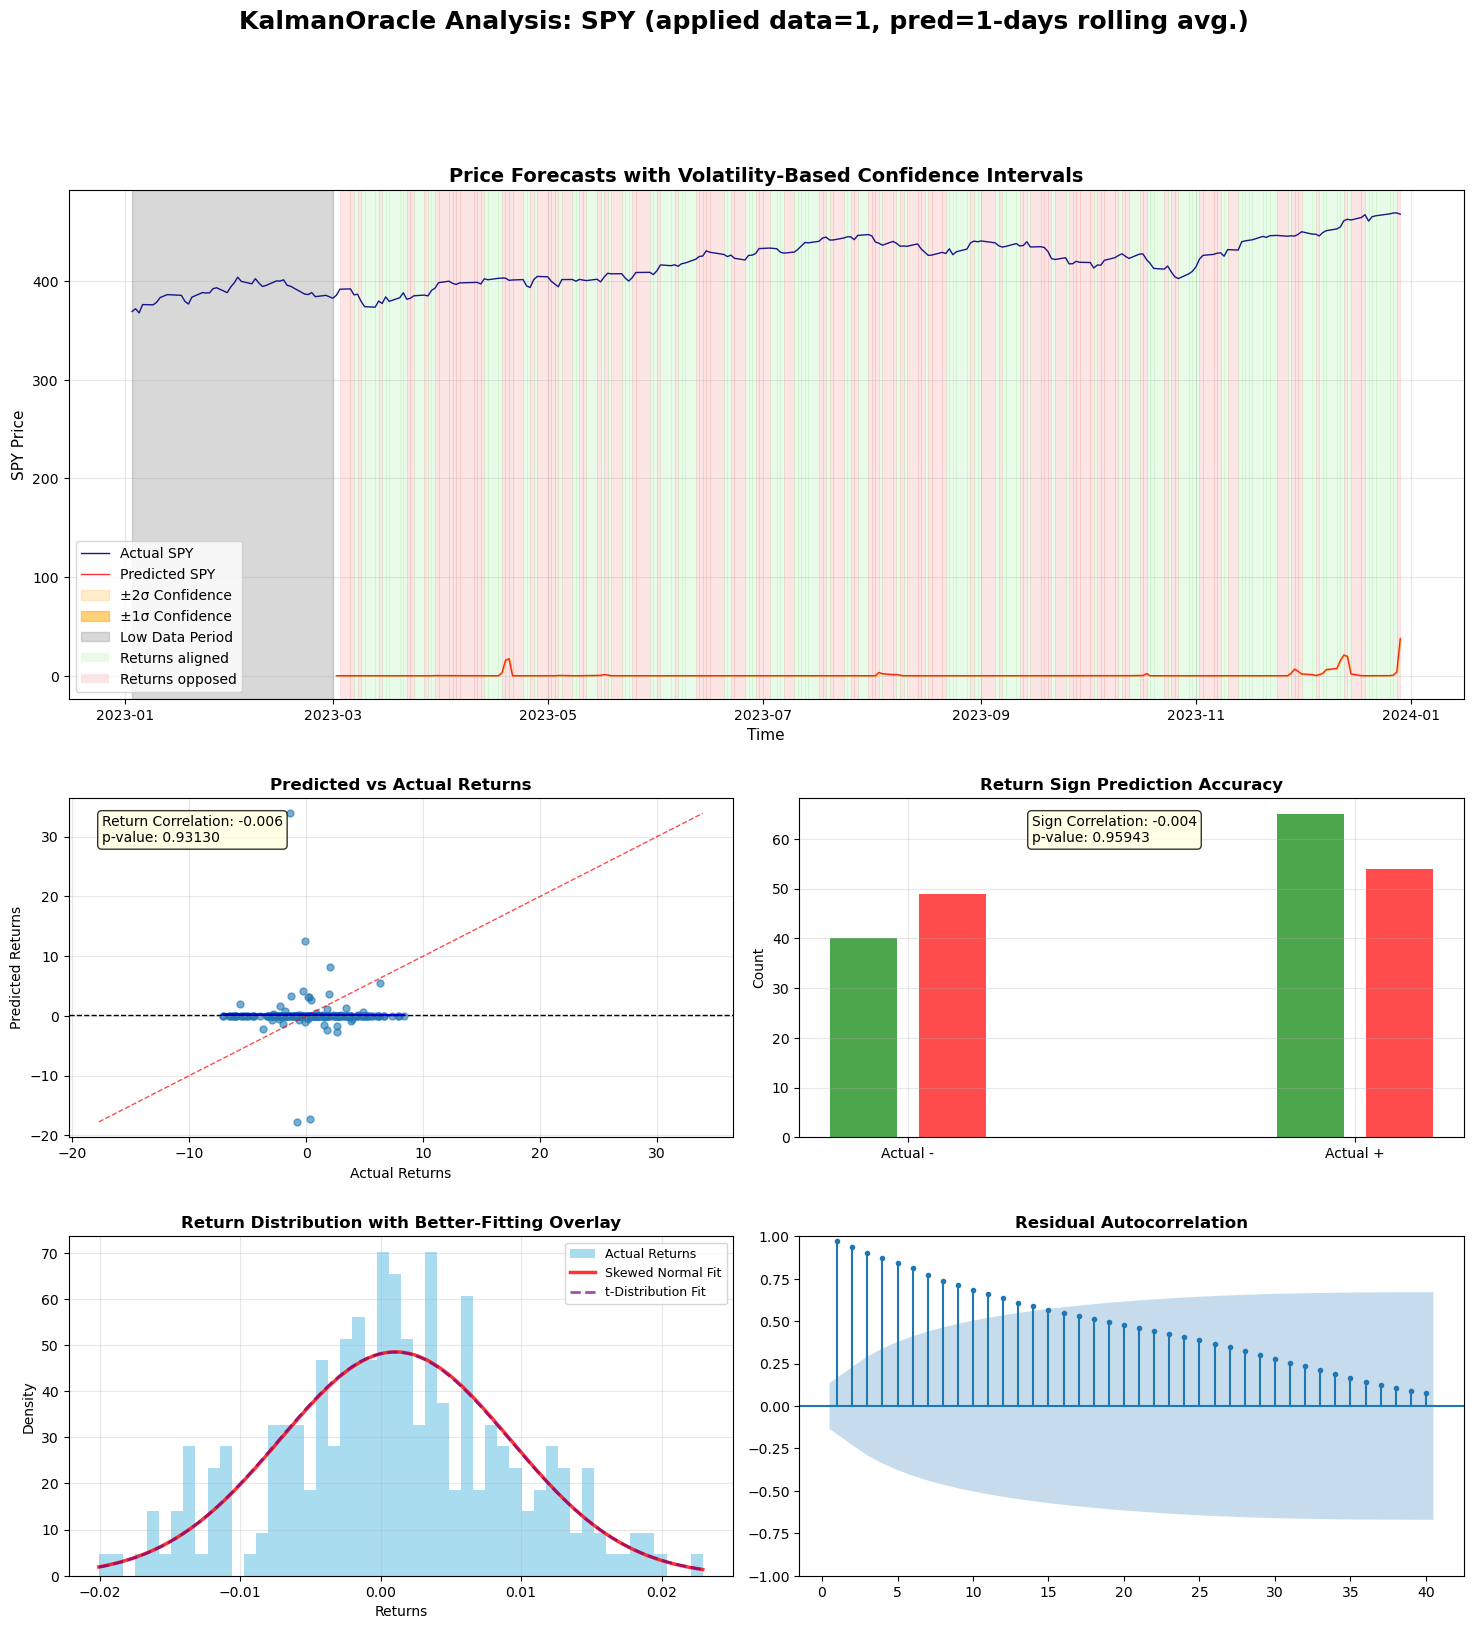

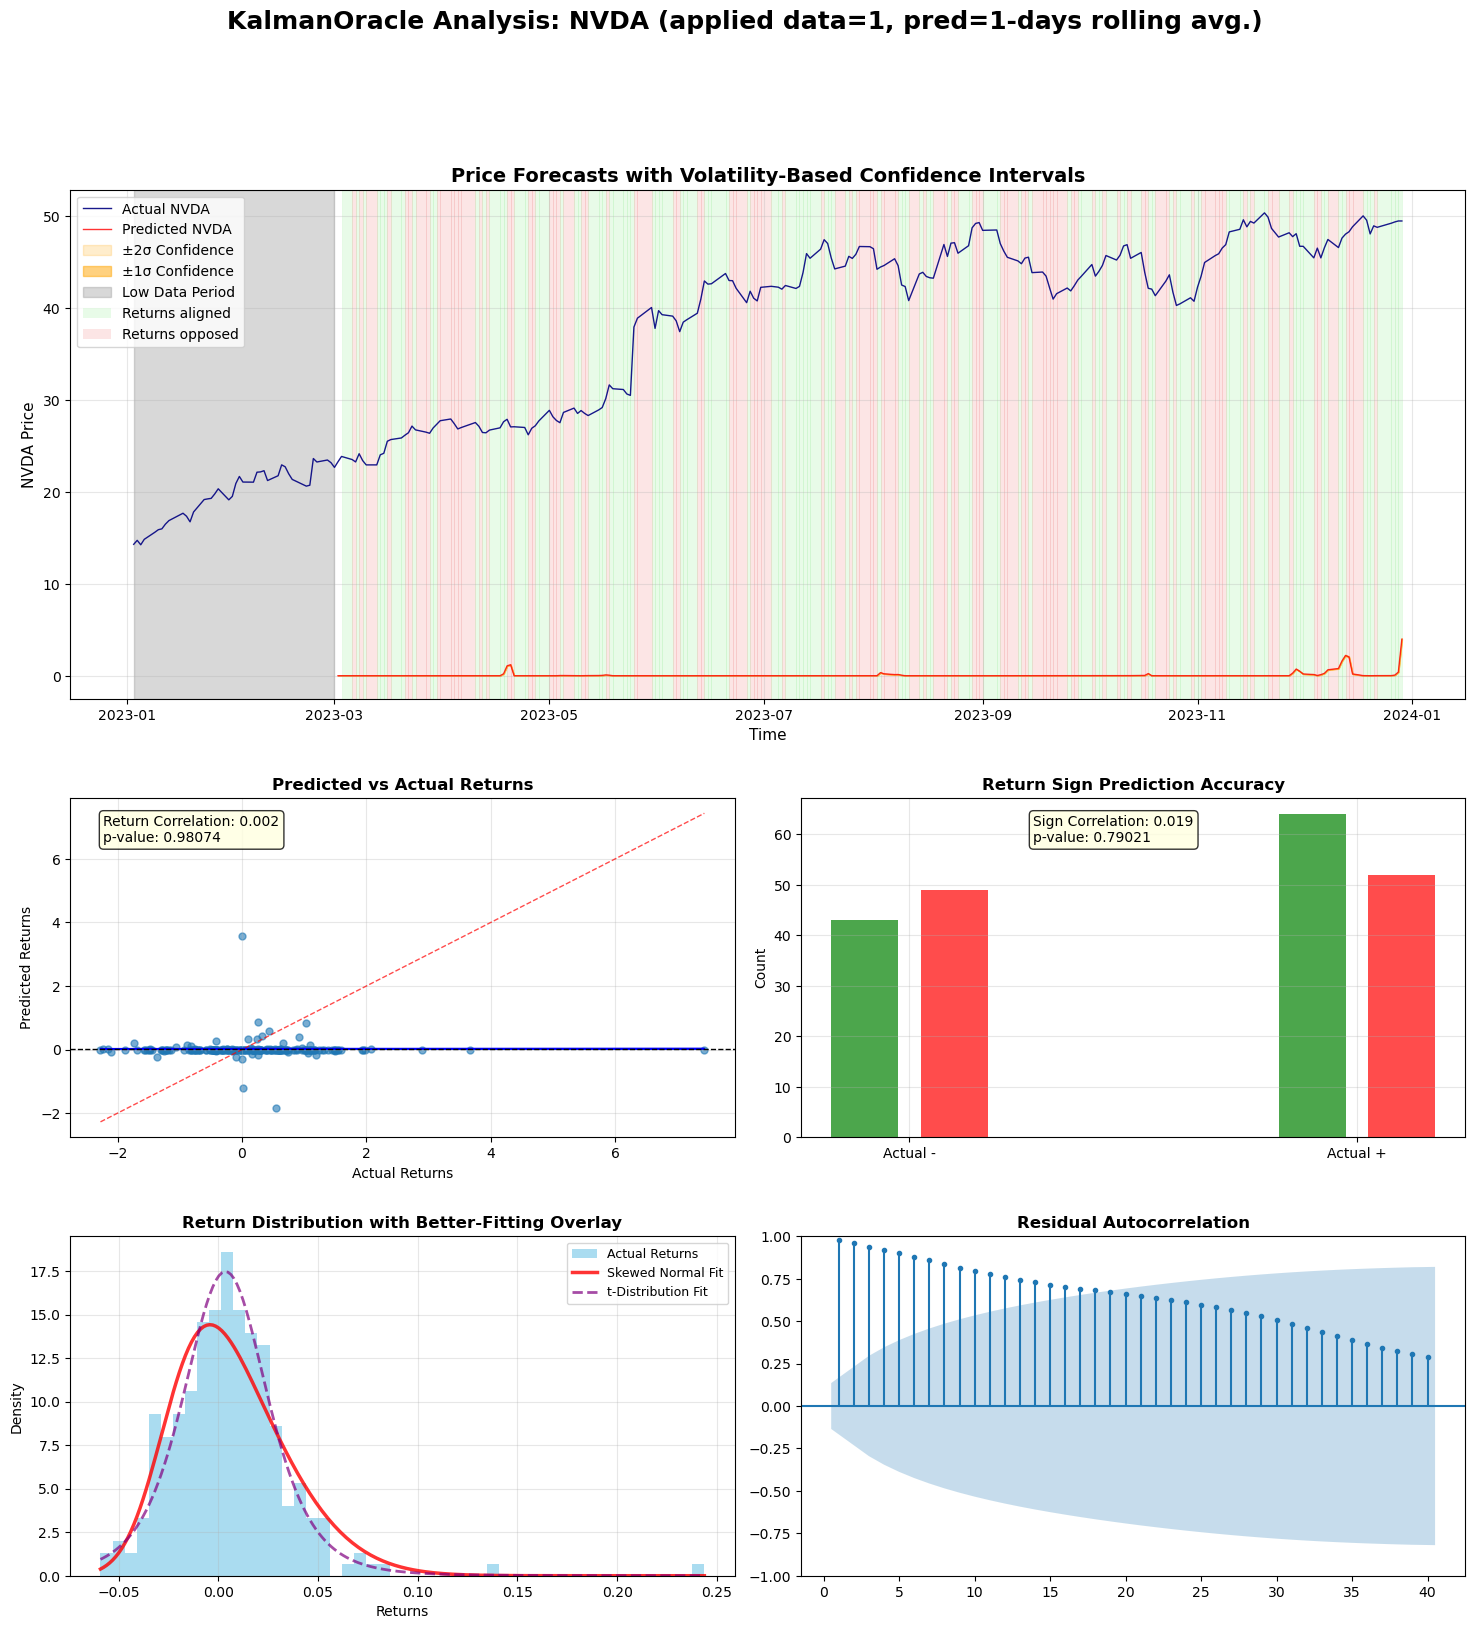

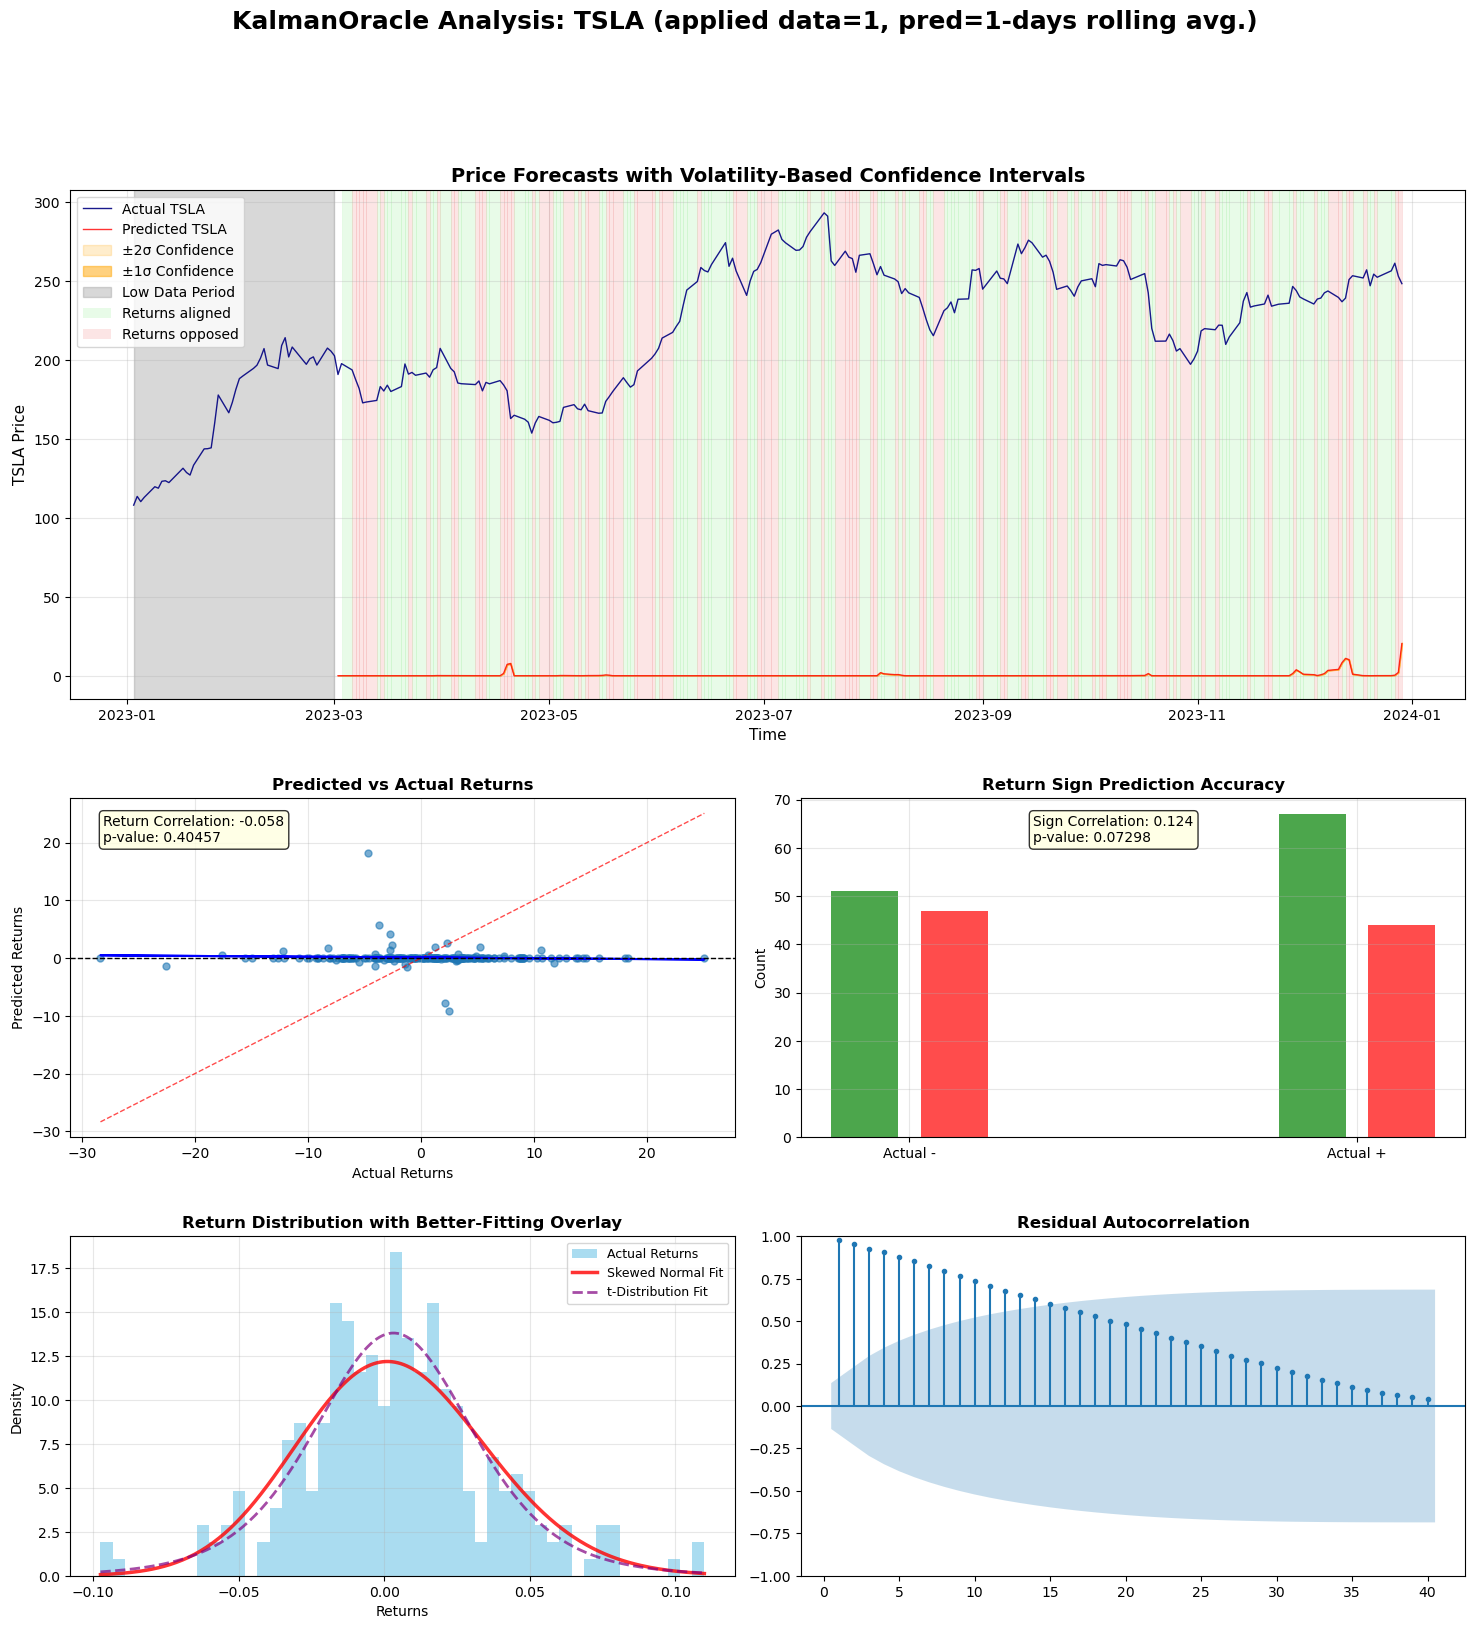

In [5]:
oracle_diagnostics(oracle=ukf_log, data=closing_data, regress_window=40, smoothing_window_data=1, smoothing_window_pred=1)

<h1>Comparison with Synthetic data (pure noise)</h1>

In [6]:
from utils.synthetic import synthetic_data

In [7]:
fake_data = synthetic_data(200, 4, [100, 20, 50, 500], [2, .5, 3, 5])
fake_df = pd.DataFrame(fake_data)

Lag Oracle is regressing: 100%|██████████| 160/160 [00:09<00:00, 17.43it/s]


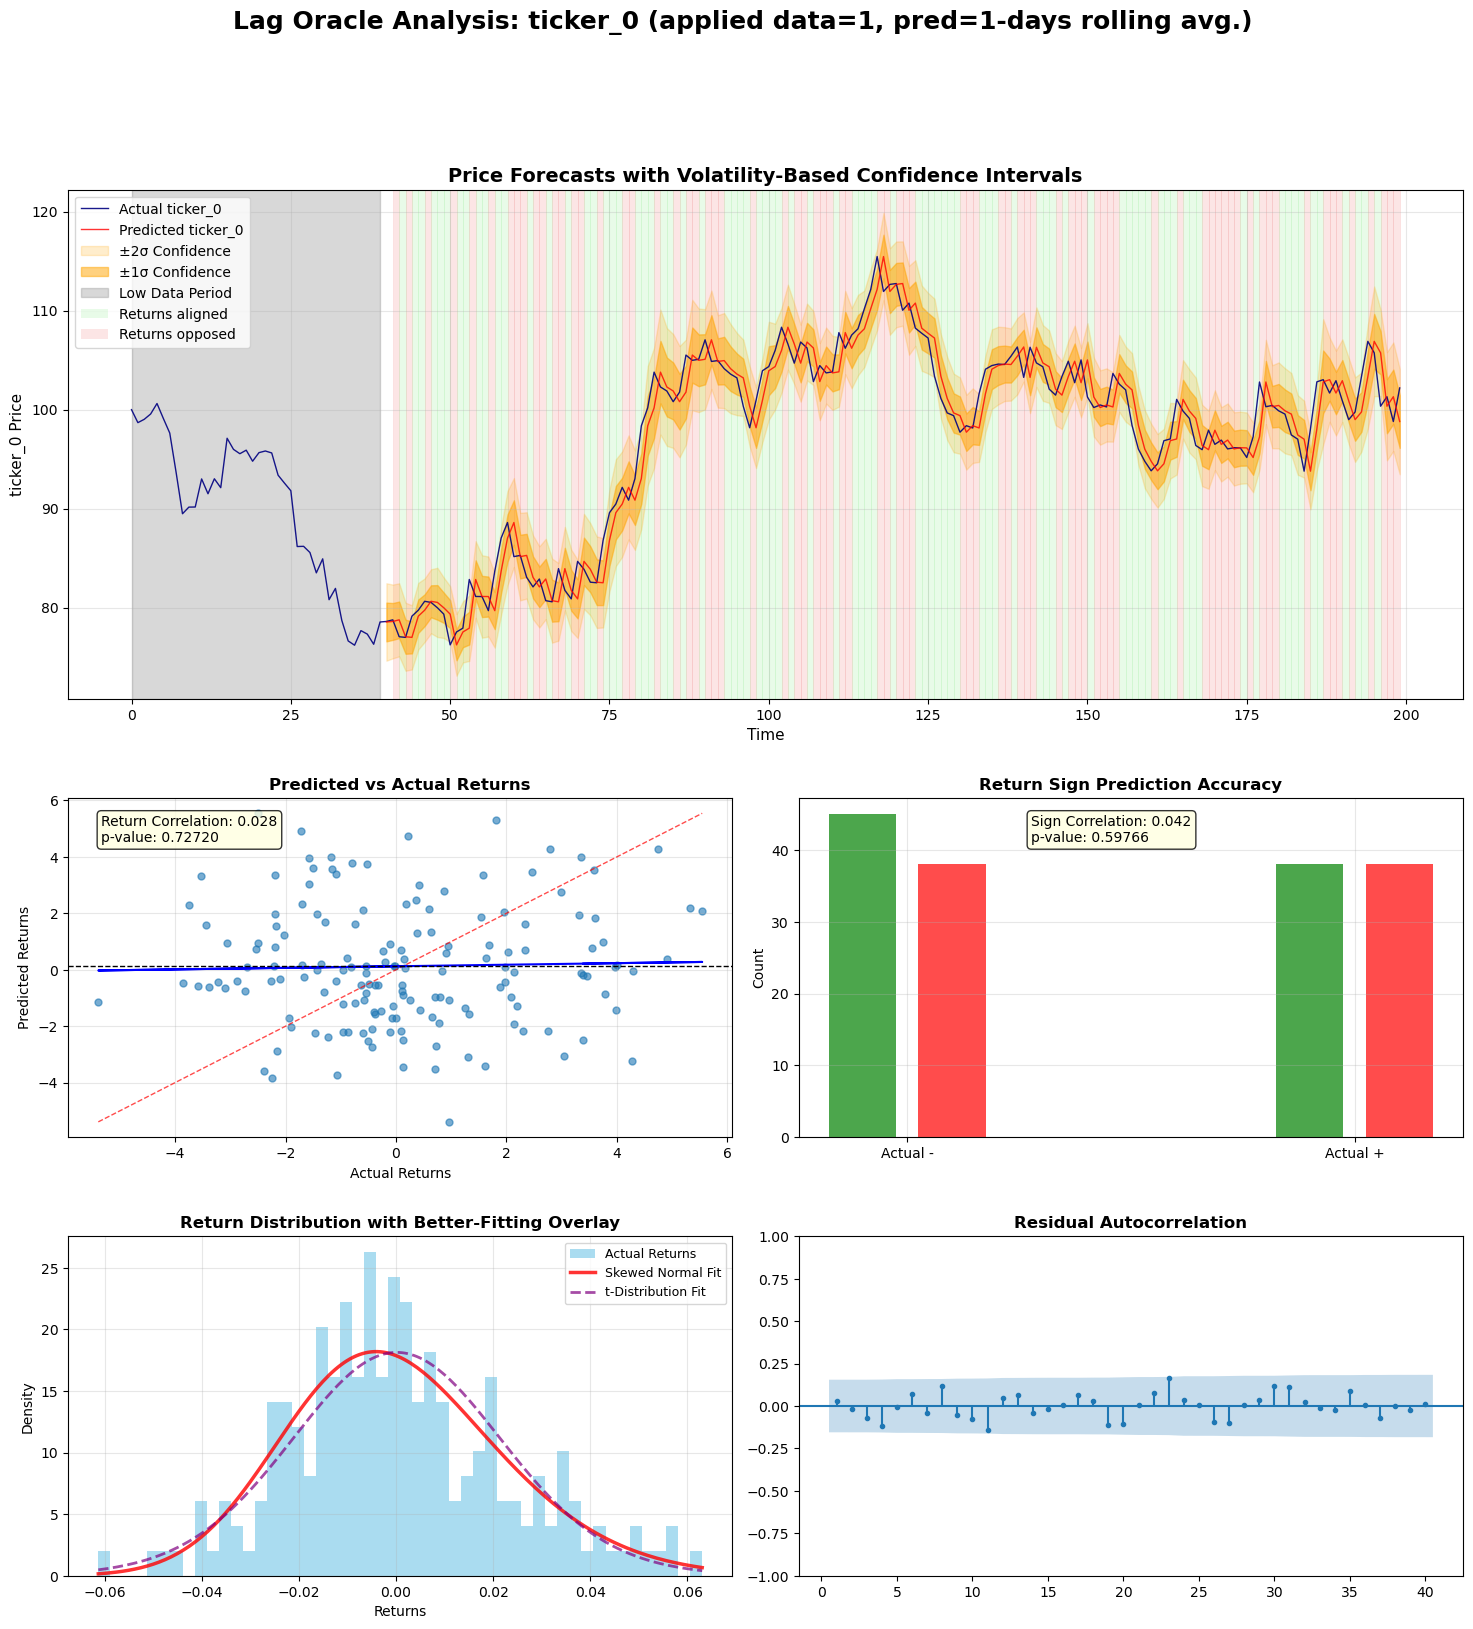

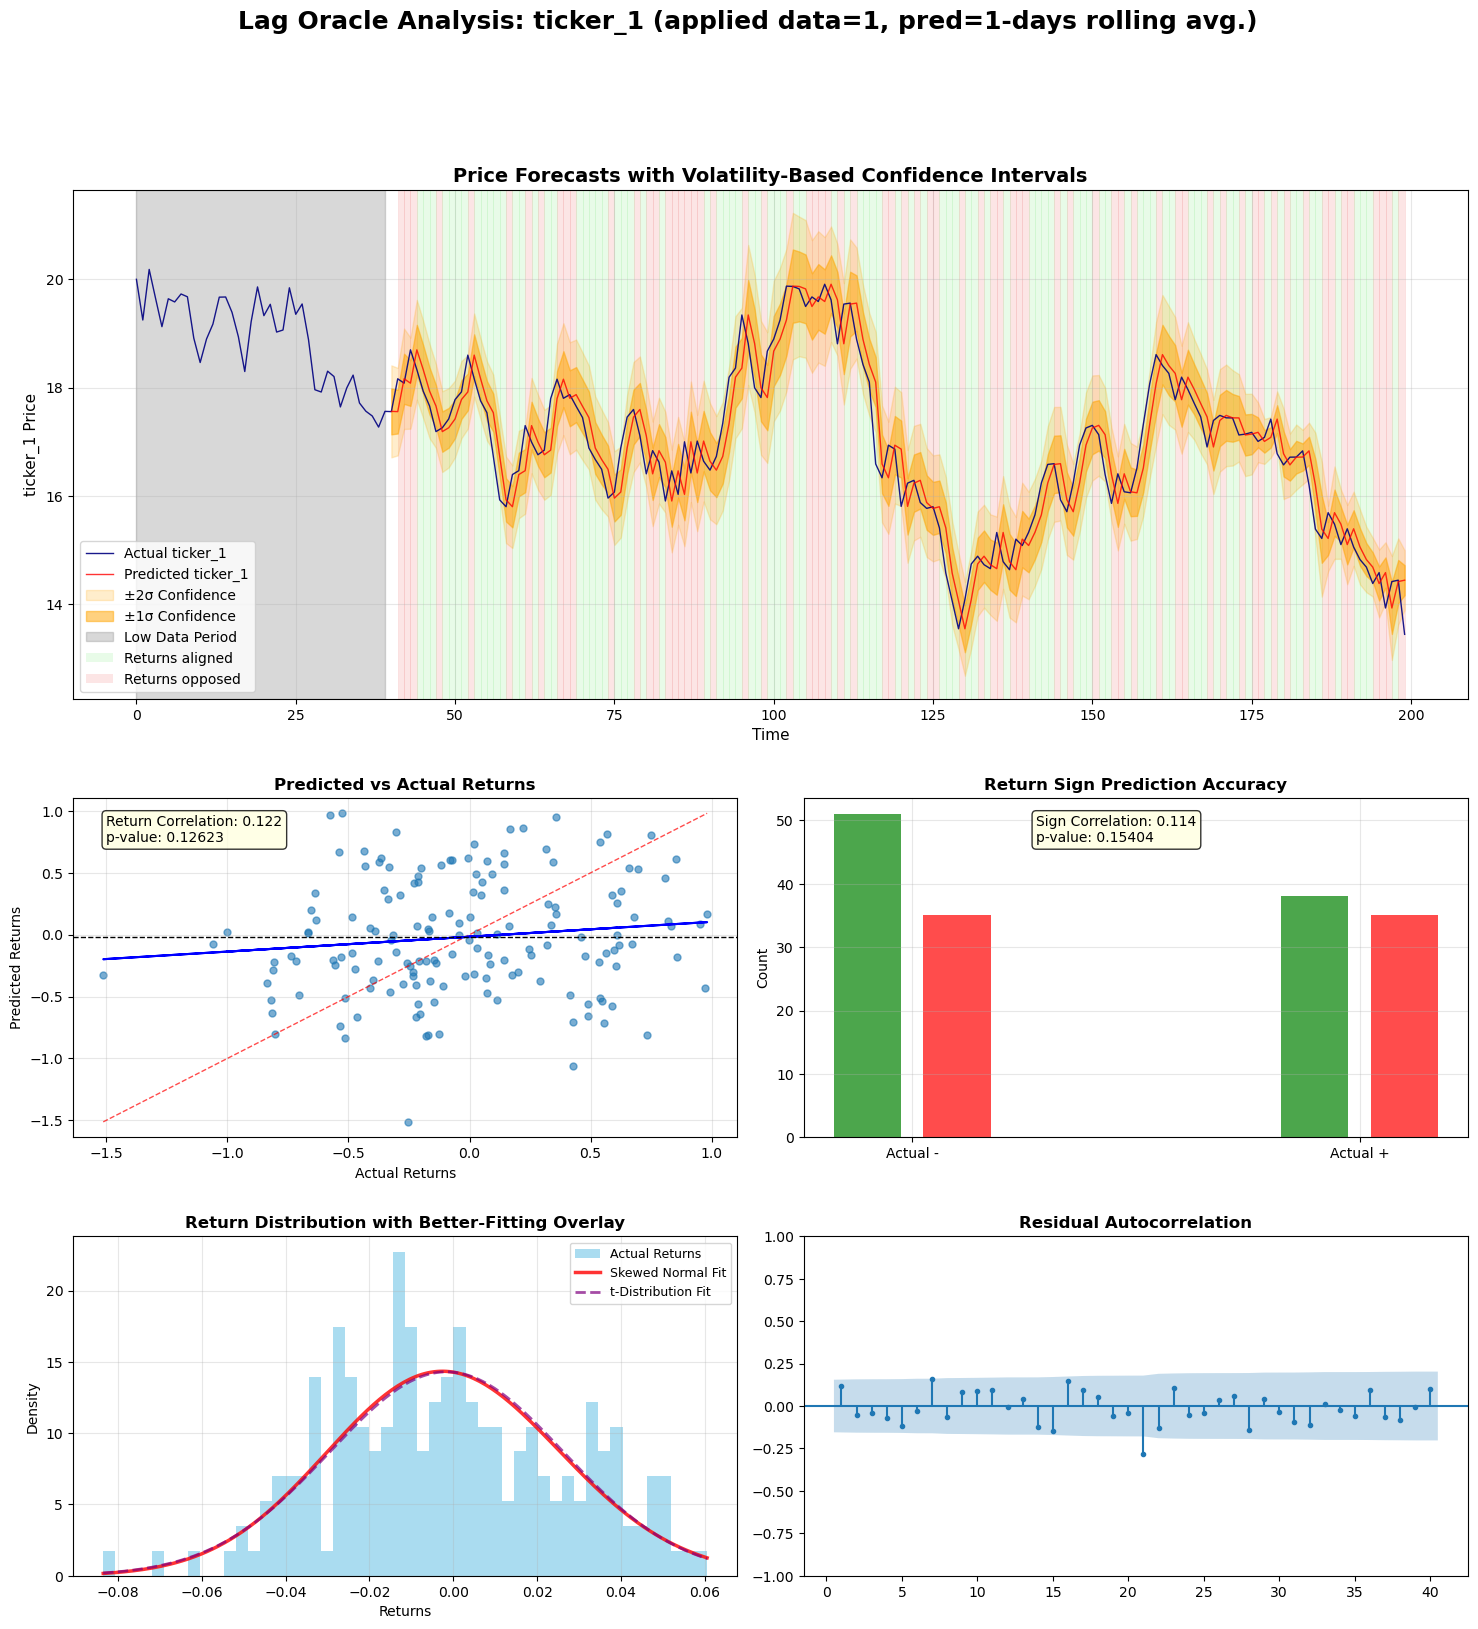

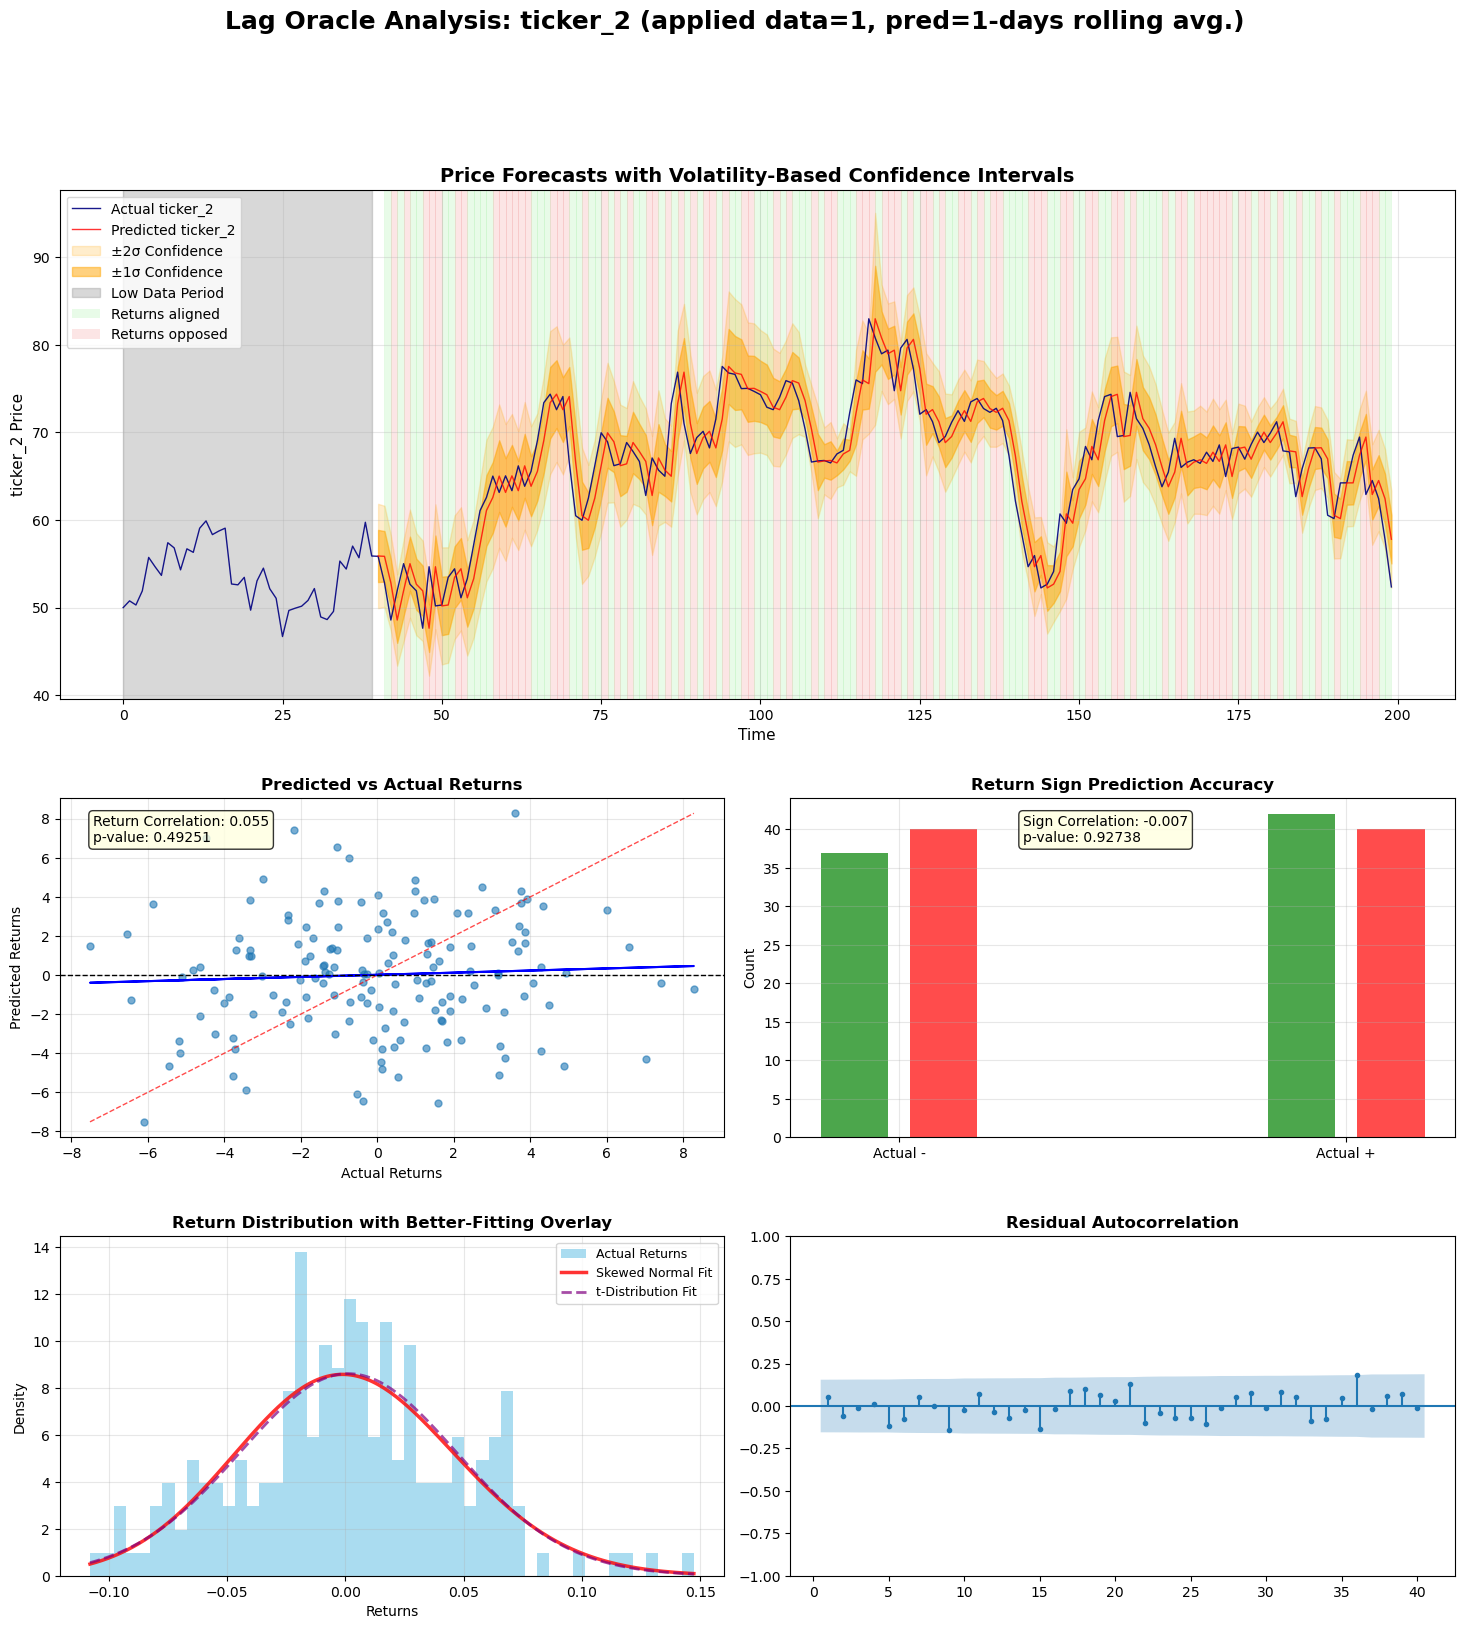

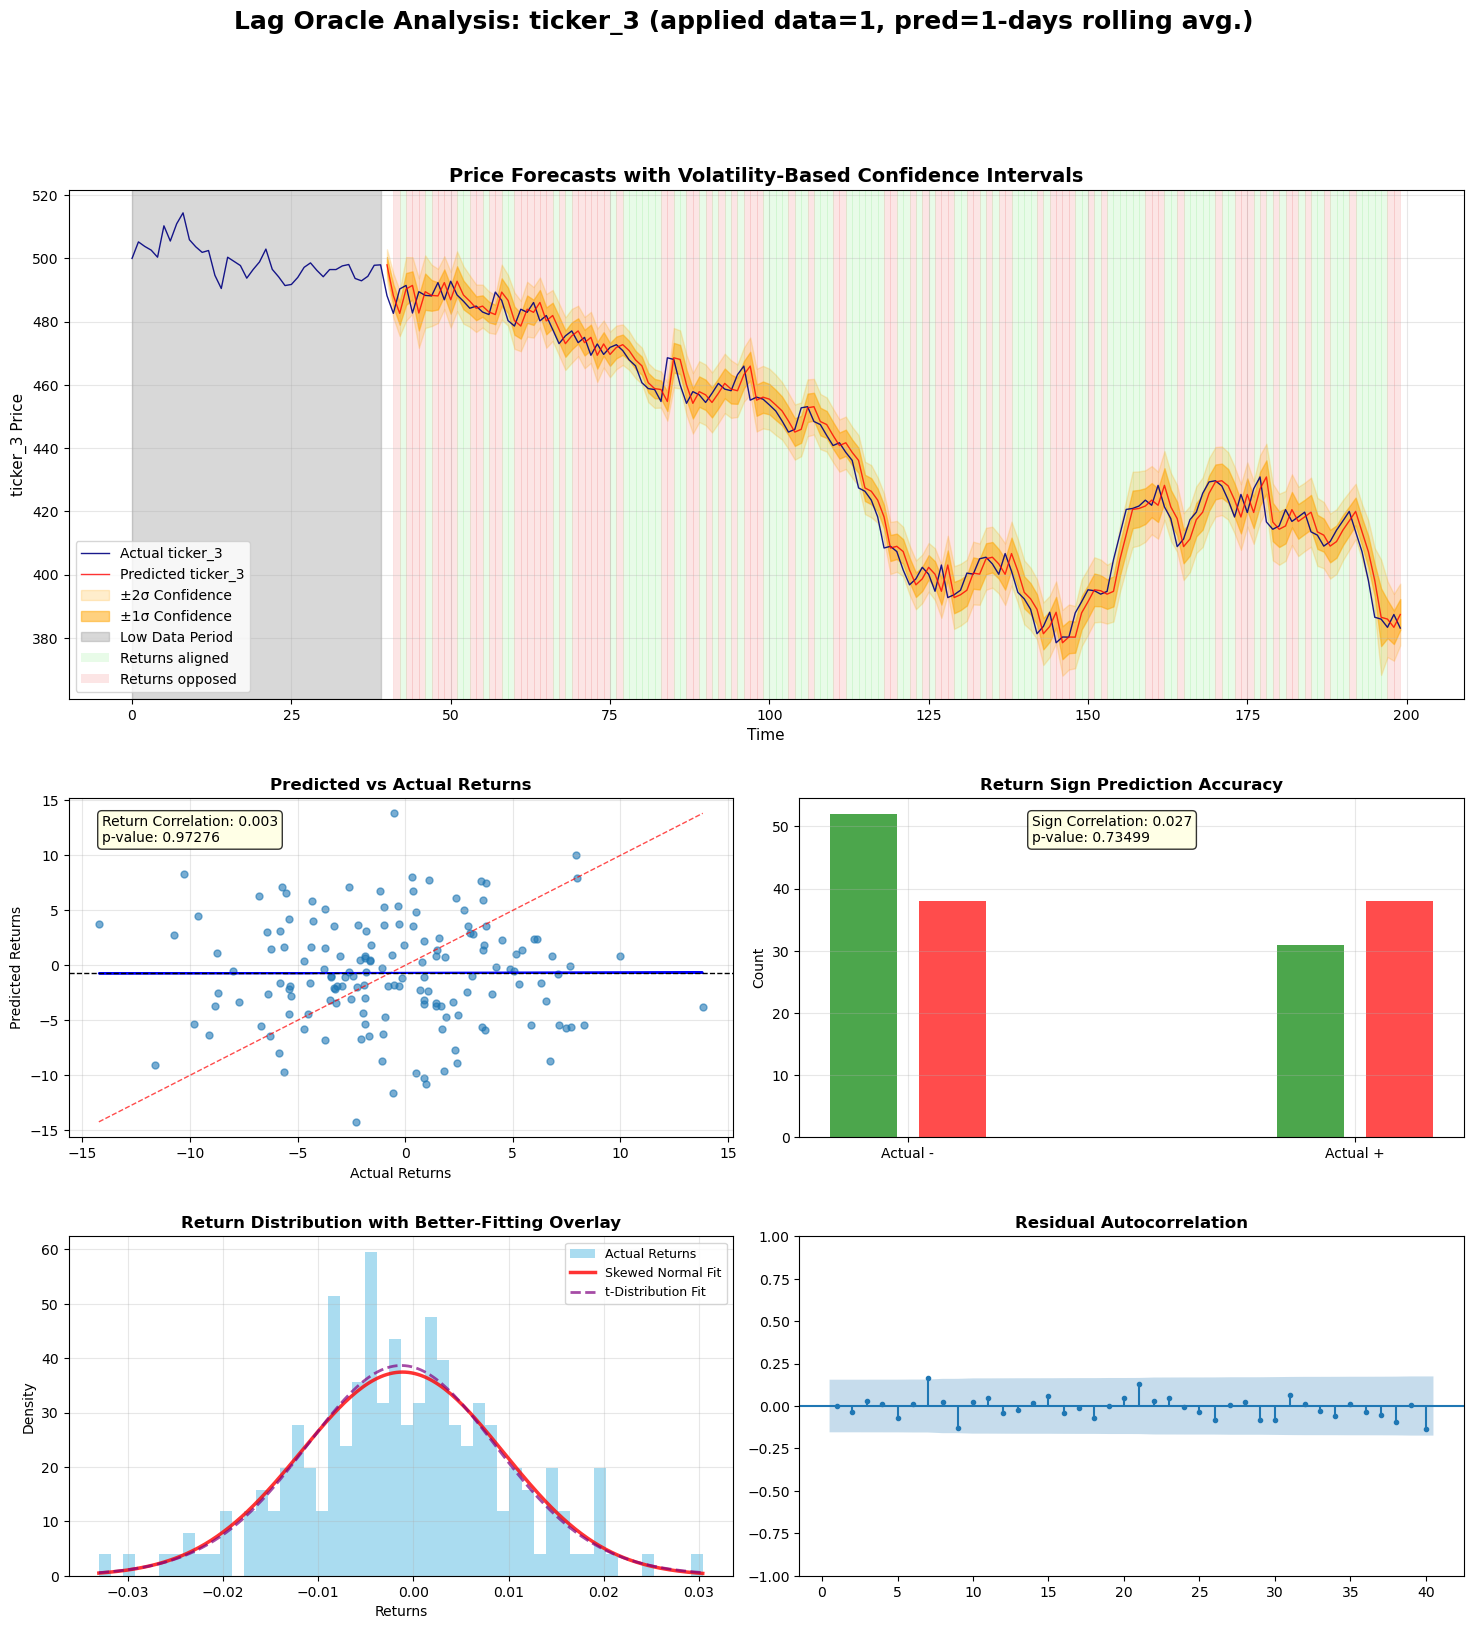

In [8]:
oracle_diagnostics(oracle=lag, data=fake_data, regress_window=40, smoothing_window_data=1, smoothing_window_pred=1)